In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from ydata_profiling import ProfileReport
from sklearn.feature_selection import SelectFromModel
import plotly.express as px  # interactive charts
import matplotlib.pyplot as plt


In [3]:
from src.utils import DatabaseManager

db=DatabaseManager()
df=db.execute_query('select * from merge_table',fetch=True)

In [8]:
df['children'].value_counts()

children
1    1128
0     638
2     421
3      53
Name: count, dtype: int64

In [4]:
children_counts = df['children'].value_counts()

fig = px.pie(children_counts, 
             values = children_counts.values, 
             names = children_counts.index,
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=20,
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.show()

In [5]:
df1=df[df.clusters=='1']
df1

,education,income,kidhome,teenhome,recency,wines,fruits,meat,fish,sweets,...,complain,response,customer_for,age,spent,living_with,children,family_size,is_parent,clusters
0,0.0,58138.0,0,0,58,635,88,546,172,88,...,0,1,663,66,1617,0.0,0,1,0.0,1
2,0.0,71613.0,0,0,26,426,49,127,111,21,...,0,0,312,58,776,1.0,0,2,0.0,1
12,0.0,63033.0,0,0,82,194,61,480,225,112,...,0,0,226,64,1102,0.0,0,1,0.0,1
15,1.0,82800.0,0,0,23,1006,22,115,59,68,...,0,1,582,77,1315,0.0,0,1,0.0,1
18,1.0,76995.0,0,1,91,1012,80,498,0,16,...,0,0,458,74,1782,1.0,1,2,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,1.0,75777.0,0,0,12,712,26,538,69,13,...,0,1,360,41,1438,0.0,0,1,0.0,1
2228,2.0,NaN,0,0,53,32,2,1607,12,4,...,0,0,686,45,1679,1.0,0,2,0.0,1
2233,0.0,666666.0,1,0,23,9,14,18,8,1,...,0,0,392,46,62,1.0,1,2,1.0,1
2235,0.0,61223.0,0,1,46,709,43,182,42,118,...,0,0,381,56,1341,1.0,1,2,1.0,1


In [85]:
cluster_purchases=df[['numdealspurchases','numwebpurchases','numcatalogpurchases','numstorepurchases','numwebvisitsmonth']]
cluster_purchases

,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth
0,3,8,10,4,7
1,2,1,1,2,5
2,1,8,2,10,4
3,2,2,0,4,6
4,5,5,3,6,5
...,...,...,...,...,...
2235,2,9,3,4,5
2236,7,8,2,5,7
2237,1,2,3,13,6
2238,2,6,5,10,3


In [81]:
import plotly.express as px

# Assuming cluster_purchases is your DataFrame with cluster-wise purchases
fig = px.bar(x=cluster_purchases.index,
             y=cluster_purchases.values,
             color=cluster_purchases.index,
             color_discrete_sequence=['#dc4c4c', '#157394', '#589cb4', '#bcb4ac', '#3c444c'],
             labels={'x': 'Clusters', 'y': 'Purchases'},
             barmode='group',  # Set barmode to 'group' for grouped bars
             text=cluster_purchases.values,  # Display the values on top of bars
             height=550,  # Adjust the height of the graph
             width=800)  # Adjust the width of the graph

fig.update_xaxes(categoryorder='total ascending', tickangle=45, title_font=dict(size=18))  # Sort, angle, and format x-axis labels
fig.update_yaxes(title_font=dict(size=18))  # Format y-axis label
fig.update_layout(xaxis_title_font=dict(size=20), yaxis_title_font=dict(size=20), plot_bgcolor='#f5f5f5')  # Customize fonts and plot background
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside', showlegend=False)  # Format text on bars and remove legend
fig.update_layout(bargap=0, bargroupgap=0)
fig.update_layout(paper_bgcolor='#1f2630',font_color='white',plot_bgcolor='#1f2630')
fig.show()


In [64]:
cam=df1[['acceptedcmp1', 'acceptedcmp2', 'acceptedcmp3', 'acceptedcmp4','acceptedcmp5', 'response']].sum()
cam

acceptedcmp1    128
acceptedcmp2     21
acceptedcmp3     50
acceptedcmp4     87
acceptedcmp5    156
response        168
dtype: int64

In [83]:
# Assuming cluster_purchases is your DataFrame with cluster-wise purchases
fig = px.bar(x=cam.index,
             y=cam.values,
             color=cam.index,
             color_discrete_sequence=['#dc4c4c', '#157394', '#589cb4', '#bcb4ac', '#3c444c'],
             labels={'x': 'campaign', 'y': 'Purchases'},
             barmode='group',  # Set barmode to 'group' for grouped bars
             text=cam.values,  # Display the values on top of bars
             height=550,  # Adjust the height of the graph
             width=800)  # Adjust the width of the graph

fig.update_xaxes(categoryorder='total ascending', tickangle=45, title_font=dict(size=18))  # Sort, angle, and format x-axis labels
fig.update_yaxes(title_font=dict(size=18))  # Format y-axis label
fig.update_layout(xaxis_title_font=dict(size=20), yaxis_title_font=dict(size=20), plot_bgcolor='#f5f5f5')  # Customize fonts and plot background
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside', showlegend=False)  # Format text on bars and remove legend
fig.update_layout(bargap=0, bargroupgap=0)
fig.update_layout(paper_bgcolor='#1f2630',font_color='white',plot_bgcolor='#1f2630')
fig.show()


In [84]:
import plotly.express as px

# Assuming cluster_purchases is your DataFrame with cluster-wise purchases
fig = px.bar(x=cluster_purchases.index,
             y=cluster_purchases.values,
             color=cluster_purchases.index,
             color_discrete_sequence=['#dc4c4c', '#157394', '#589cb4', '#bcb4ac', '#3c444c'],
             labels={'x': 'Clusters', 'y': 'Purchases'},
             barmode='group',  # Set barmode to 'group' for grouped bars
             text=cluster_purchases.values,  # Display the values on top of bars
             height=550,  # Adjust the height of the graph
             width=800)  # Adjust the width of the graph

fig.update_xaxes(categoryorder='total ascending', tickangle=45, title_font=dict(size=18))  # Sort, angle, and format x-axis labels
fig.update_yaxes(title_font=dict(size=18))  # Format y-axis label
fig.update_layout(xaxis_title_font=dict(size=20), yaxis_title_font=dict(size=20), plot_bgcolor='#f5f5f5')  # Customize fonts and plot background
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside', showlegend=False)  # Format text on bars and remove legend
fig.update_layout(bargap=0, bargroupgap=0)
fig.update_layout(paper_bgcolor='#1f2630',font_color='white')
fig.show()


(array([0]), [Text(0, 0, '1')])

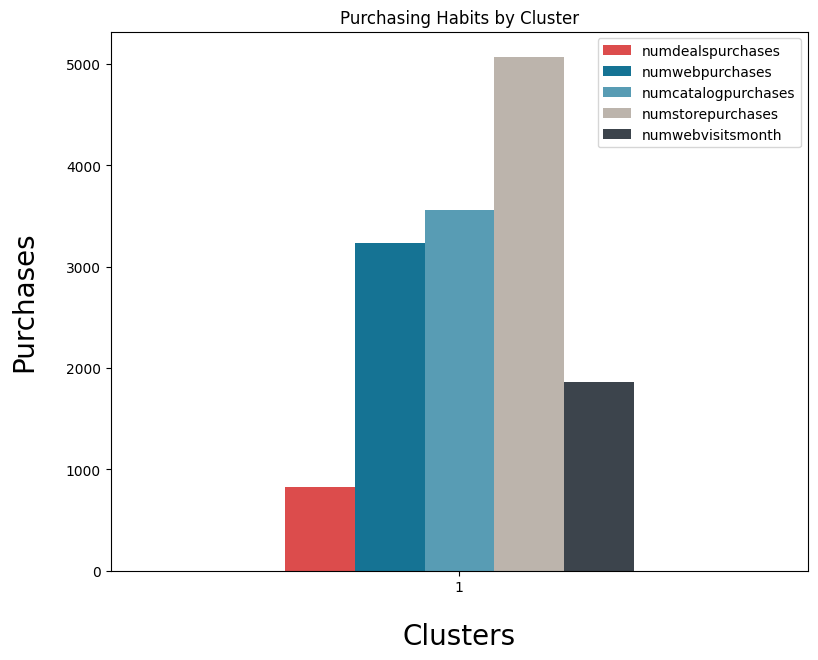

In [8]:
cluster_purchases = df1.groupby('clusters')[['numdealspurchases', 'numwebpurchases', 'numcatalogpurchases',
                                                  'numstorepurchases', 'numwebvisitsmonth']].sum()

cluster_purchases.plot(kind='bar', color=['#dc4c4c','#157394','#589cb4','#bcb4ac','#3c444c'], figsize=(9,7))

plt.title('Purchasing Habits by Cluster')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('Purchases', fontsize=20, labelpad=20)
plt.xticks(rotation=0, ha='center')

In [37]:
income=df[df.clusters=='1'].income.mean()

In [41]:
((55000-income)/income)*100

-29.0944371959651

In [33]:
df.income.mean()-40000

12247.251353790612

In [44]:
result = df.groupby('clusters')['income'].agg(
    mean='mean',
    median='median',
    min='min',
    max='max'
).reset_index()

result

,clusters,mean,median,min,max
0,0,30923.380414,30368.0,1730.0,66503.0
1,1,77567.961983,76045.0,44953.0,666666.0
2,2,50704.685009,51651.0,6835.0,94871.0
3,3,46491.153707,46344.0,4023.0,83891.0


<Axes: xlabel='income', ylabel='Count'>

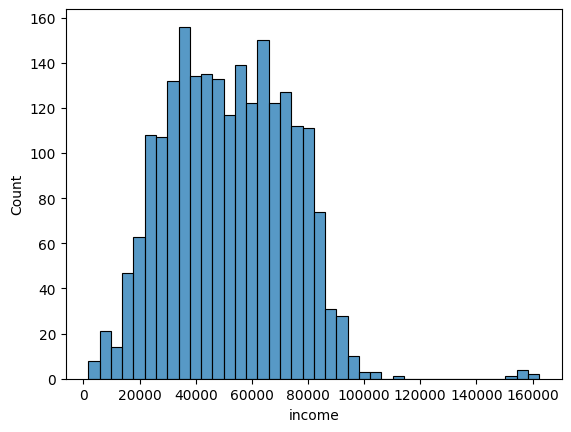

In [15]:
import seaborn as sns
sns.histplot(df.income[df.income<600000],bins=40)